<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/Word_embeddings_colaboratory_27_2_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Loading packages

In [2]:
!pip install fastai --upgrade
!pip install dtreeviz
!pip install fastbook

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 61 kB 890 bytes/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.3-py3-none-any.whl size=67113 sha256=7c8a846fdc7a0b81ae594cc0b43aac4e44f413f683d9b97432a8062f0ba5cd41
  Stored in directory: /root/.cache/pip/wheels/58/9d/65/e57deb90bf5440945d74bc4c19ebb14a0de2ed2b508c609673
Successfully built dtreeviz
     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 48 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 173 kB/s 
     |████████████████████████████████| 558 kB 55.0 MB/s 
     |████████████████████████████████| 130 kB 53.9 MB/s 
  Attempting uninstall: jupyter-client
  

In [3]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [60]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from collections import Counter
import seaborn as sns


pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data

In [5]:
path = "/content/gdrive/MyDrive/archivos_tfm/saezr_nc19_DataS1_modificado.xlsx"
sheet_to_df_map = pd.read_excel(path, sheet_name=None)
df_drug_comb = sheet_to_df_map["Drug combinations Ch1"]


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,QA,Combination ID,Challenge,Dataset
0,BT-20,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
1,CAL-120,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
2,CAL-51,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
3,DU-4475,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
4,HCC1143,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
5,HCC1187,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
6,HCC1428,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
7,HCC1806,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
8,HCC1937,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
9,HCC70,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train


In [7]:
df_drug_comb.columns


Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset'],
      dtype='object')

In [8]:
print("Splits: ",df_drug_comb['Dataset'].unique())
print("Challenge: ",df_drug_comb['Challenge'].unique())

Splits:  ['train' 'LB' 'test']
Challenge:  ['ch1']


In this dataset we have a train/test/Leaderboard split. Also, all of our data refers to challege 1, so we can just drop that column later.

In [9]:
# A little bit of data analysis
df_drug_comb.describe()

,Max. conc. A,Max. conc. B,IC50 A,H A,...,H B,Einf B,Synergy score,QA
count,3879.000000,3879.000000,3879.000000,3879.000000,...,3879.000000,3879.000000,3879.000000,3879.000000
mean,1.721684,4.960581,0.733284,2.900107,...,2.902762,48.091803,10.236308,0.758443
std,1.818286,14.657023,1.021671,3.634496,...,3.704492,35.876790,116.249064,0.742968
min,0.003000,0.003000,0.000003,0.000000,...,0.000000,0.000000,-588.220700,-3.000000
25%,1.000000,1.000000,0.069179,0.507272,...,0.432883,12.537512,-5.246305,1.000000
50%,1.000000,1.000000,0.337817,1.264897,...,1.177369,47.599717,8.429529,1.000000
75%,3.000000,3.000000,1.000000,2.989752,...,3.014471,82.398922,25.385300,1.000000
max,10.000000,75.000000,10.000000,10.000000,...,10.000000,100.000000,6737.175000,1.000000


We will choose to train only in high quality data, meaning QA=1.

In [10]:
df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
print("Values of QA:", df_drug_comb["QA"].unique())

Values of QA: [1]


We drop QA, Combination ID and Challenge.

In [11]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset'],
      dtype='object')

In [12]:
df_drug_comb.drop(['QA','Challenge'], axis = 1, inplace = True)

SettingWithCopyError: ignored

It gives a warning but it has succesfully dropped QA and Challenge columns from the DataFrame.

In [13]:
df_drug_comb.head()

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf B,Synergy score,Combination ID,Dataset
0,BT-20,AKT,ADAM17,1.0,...,91.593425,29.540390,ADAM17.AKT,train
2,CAL-51,AKT,ADAM17,1.0,...,76.656479,0.315422,ADAM17.AKT,train
5,HCC1187,AKT,ADAM17,1.0,...,100.000000,-0.801993,ADAM17.AKT,train
7,HCC1806,AKT,ADAM17,1.0,...,48.650054,-26.733250,ADAM17.AKT,train
8,HCC1937,AKT,ADAM17,1.0,...,92.188029,32.165520,ADAM17.AKT,train


In [14]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID', 'Dataset'],
      dtype='object')

In [15]:
dep_var = 'Synergy score'
procs = [Categorify, FillMissing]


In [16]:
# We shuffle the data
df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf B,Synergy score,Combination ID,Dataset
0,HCC1143,FGFR,EGFR,1.00,...,64.986248,25.848650,EGFR.FGFR,test
1,MDA-MB-468,PIK3C,AKT_1,3.00,...,69.899766,24.378630,AKT_1.PIK3C,train
2,MFM-223,MAP2K_1,ATR_4,1.00,...,75.098838,-19.085140,ATR_4.MAP2K_1,train
3,BT-20,MTOR_1,FASN,1.00,...,14.386142,20.951370,FASN.MTOR_1,test
4,SW948,IGFR_3,IAP,10.00,...,54.853758,40.200730,IAP.IGFR_3,test
5,MDA-MB-453,MTOR_1,ADAM17,1.00,...,100.000000,-11.081940,ADAM17.MTOR_1,train
6,NCI-H838,CarboTaxol,BCL2,0.01,...,50.667217,14.439270,BCL2.CarboTaxol,LB
7,SW900,TOP2,ALK_2,3.00,...,0.000000,-21.021490,ALK_2.TOP2,train
8,MDA-MB-361,MTOR_3,FGFR,1.00,...,61.467582,0.288488,FGFR.MTOR_3,test
9,HCC1937,PIK3CA_4,MTOR_1,1.00,...,50.879998,3.537330,MTOR_1.PIK3CA_4,train


We create the train/test/LB splits and then create a copy of our dataset without the Combination ID. 
We want to retain the Combination ID because we use it for our Weighted Pearson metric.

In [17]:
dataset_size = df_drug_comb.shape[0]
complete_list = np.arange(dataset_size, dtype = int)

train_idx = complete_list[df_drug_comb["Dataset"]=="train"]
test_idx = complete_list[df_drug_comb["Dataset"]=="test"]
LB_idx = complete_list[df_drug_comb["Dataset"]=="LB"]

# For now we ignore the LB split

splits = (list(train_idx),list(test_idx))

df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
df_nocomb = df_drug_comb.drop(['Combination ID'], axis = 1)


In [18]:
print("With Combination ID: ", df_drug_comb.columns)
print("Without Combination ID:", df_nocomb.columns )

With Combination ID:  Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID'],
      dtype='object')
Without Combination ID: Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score'],
      dtype='object')


In [19]:
cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)

In [20]:
len(to.train),len(to.valid)

(1795, 1089)

In [21]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

### Understanding xs, ym valid_xs, valid_y

In [22]:
xs.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B'],
      dtype='object')

In [23]:
xs.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf A,IC50 B,H B,Einf B
1,50,32,3,3.0,...,0.000000,0.327204,10.000000,69.899765
2,51,25,9,1.0,...,100.000000,0.368849,10.000000,75.098839
5,49,28,1,1.0,...,14.599023,1.000000,0.000000,100.000000
7,77,50,6,3.0,...,61.816383,2.149279,0.731725,0.000000
9,27,34,41,1.0,...,86.199829,1.000000,0.900497,50.879997
11,10,37,3,1.0,...,45.571762,0.261342,1.071766,0.000000
12,26,49,31,1.0,...,1.733648,0.011699,10.000000,94.774933
13,9,18,4,1.0,...,48.294754,0.125689,1.222968,74.233620
14,27,49,41,1.0,...,47.170940,1.000000,0.929727,59.556419
15,20,28,39,1.0,...,10.386720,0.013501,1.144306,49.805904


It converts categorical variables into numerical ones. 

In [24]:
to.classes["Compound A"]

['#na#', 'AKT', 'AKT_1', 'ALK_IGFR', 'ATR_4', 'BCL2L1', 'BCL2_2', 'BCL2_BCL2L1', 'CSNK2A1_2', 'CarboTaxol', 'Chloroquine', 'Cisplatin', 'EGFR', 'EGFR_2', 'ERBB', 'ESR1', 'ESR1_1', 'FASN', 'FGFR', 'Gemcitabine', 'HDAC_4', 'IAP', 'IGFR_3', 'IGFR_4', 'JAK', 'MAP2K_1', 'MAP2K_3', 'MTOR', 'MTOR_1', 'MTOR_3', 'Oxaliplatin', 'PARP1', 'PIK3C', 'PIK3CA_3', 'PIK3CA_4', 'PIK3CB', 'PIK3CB_PIK3CD', 'PIK3C_2', 'PIK3C_MTOR', 'PIM1', 'PIP5K1', 'PTK2', 'Proteasome_2', 'SLC16A4', 'SN38', 'SYK', 'TKI', 'TNF', 'TNFSF10', 'TNKS_PARP6', 'TOP2', 'TOP2_2', 'Topotecan', 'Vinorelbine', 'WNT']

In [25]:
df_nocomb["Compound A"].unique()

array(['FGFR', 'PIK3C', 'MAP2K_1', 'MTOR_1', 'IGFR_3', 'CarboTaxol', 'TOP2', 'MTOR_3', 'PIK3CA_4', 'PIK3CB', 'PIK3C_2', 'TNKS_PARP6', 'EGFR', 'SLC16A4', 'ALK_IGFR', 'PIP5K1', 'JAK', 'PIK3CA_3',
       'Topotecan', 'PTK2', 'PIM1', 'TNF', 'PIK3CB_PIK3CD', 'IAP', 'CSNK2A1_2', 'PARP1', 'Gemcitabine', 'AKT_1', 'Cisplatin', 'Vinorelbine', 'ESR1_1', 'HDAC_4', 'ERBB', 'BCL2_BCL2L1', 'TNFSF10',
       'EGFR_2', 'ATR_4', 'WNT', 'IGFR_4', 'MAP2K_3', 'FASN', 'SN38', 'Oxaliplatin', 'TOP2_2', 'Proteasome_2', 'Chloroquine', 'PIK3C_MTOR', 'BCL2_2', 'BCL2L1', 'TKI', 'AKT', 'ESR1', 'MTOR', 'SYK'],
      dtype=object)

When we do to.classes there appears a "#na#" item that does not appear in the original DataFrame. Ask Pablo about that.

In [26]:
y

1       24.378630
2      -19.085140
5      -11.081940
7      -21.021490
9        3.537330
          ...    
3468   -23.168930
3470    -1.023761
3471    12.894160
3472    19.809669
3473    47.096230
Name: Synergy score, Length: 1795, dtype: float32

# Baseline model: mean and median

  Let's see how good it performs a model whose only information is the mean or the median of the train set.

In [27]:
mean = np.mean(y)
median = np.median(y)
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.755132675170898 
 Mean = 12.747149467468262


We create our metrics

In [28]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [29]:
error_mean = r_mse(mean, valid_y)
error_median = r_mse(median, valid_y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.020176 
 Error Mean = 27.897857


However, we now know that the correct metric is going to be a weighted Pearson correlation coefficient, which takes into account the number of cell lines used per drug pair experiment. It will give 0 for uncorrelated data.

What we want to measure is if the experimental and predicted synergy scores are correlated for every drug pair.

In [30]:
def weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        rho_list.append(pearson[0,1])
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*pearson[0,1]
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

In [31]:
test_df = df_drug_comb.iloc[test_idx]
test_df

,Cell line name,Compound A,Compound B,Max. conc. A,...,H B,Einf B,Synergy score,Combination ID
0,HCC1143,FGFR,EGFR,1.0,...,1.106136,64.986248,25.848650,EGFR.FGFR
3,BT-20,MTOR_1,FASN,1.0,...,0.620699,14.386142,20.951370,FASN.MTOR_1
4,SW948,IGFR_3,IAP,10.0,...,0.794861,54.853758,40.200730,IAP.IGFR_3
8,MDA-MB-361,MTOR_3,FGFR,1.0,...,0.516637,61.467582,0.288488,FGFR.MTOR_3
10,NCI-H1437,PIK3CB,IAP,3.0,...,0.399422,43.252022,51.634870,IAP.PIK3CB
...,...,...,...,...,...,...,...,...,...
3459,HCC1806,MTOR_1,FASN,1.0,...,10.000000,75.080116,-50.139620,FASN.MTOR_1
3460,RKO,TKI,MAP2K_1,3.0,...,0.969392,0.000000,11.056320,MAP2K_1.TKI
3461,CAL-120,TNKS_PARP6,PIK3CB_PIK3CD,1.0,...,10.000000,70.299621,14.689200,PIK3CB_PIK3CD.TNKS_PARP6
3469,NCI-H1975,TOP2_2,IAP,3.0,...,0.493178,71.768277,46.534060,IAP.TOP2_2


**Sanity check:** we try the metric by predicting values around the mean of the synergy score of the train split. As this values are random, statistically they will be uncorrelated with the experimental values. We should obtain a weighted Pearson score close to 0.

In [32]:
n_exp = len(test_idx)
y_pred = np.ones(n_exp)* mean  + np.random.random(n_exp)*1000
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)

Weighted Pearson:  0.03331663603851773


It's very small and oscillates around 0. 




# Decision Trees


In [33]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

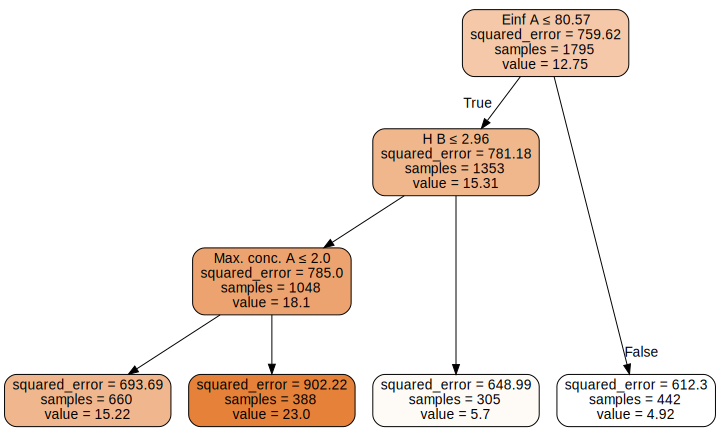

In [34]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


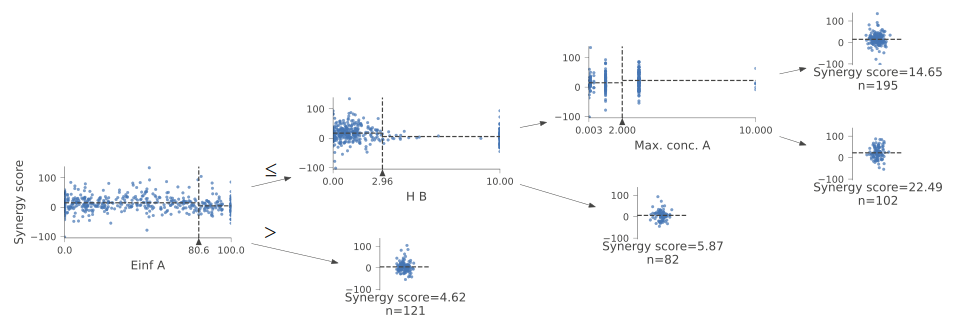

In [35]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [36]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [37]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [38]:
m_rmse(m, valid_xs, valid_y)


36.81299

Now we will check for overfitting:

In [39]:
m.get_n_leaves(), len(xs)

(1795, 1795)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [40]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.997595, 28.145969)

In [41]:
m.get_n_leaves()


55

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [42]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [43]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 152 
 Error = 27.38495


Let's check our metric

In [44]:
m = DecisionTreeRegressor(min_samples_leaf = best_leaf)
m.fit(to.train.xs, to.train.y)
y_pred = m.predict(valid_xs)
print(test_df.shape)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)


(1089, 13)
Weighted Pearson:  nan
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


For some drug combination we obtain NaN's. My hypothesis is that for some drug pairs the predicted value is the same for all cell lines.

In [45]:
check_nan = pear_weights_df["Pearson coefficient"].isnull()
combination_index = np.arange(pear_weights_df.shape[0], dtype = int)
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

,Combination ID,n_cl,Pearson coefficient
54,ALK.CSNK2A1_2,6,NaN
96,MTOR_1.TNKS_PARP6,7,NaN
133,Cisplatin.PIK3C,3,NaN
138,AKT.Cisplatin,3,NaN
148,AKT.Chloroquine,5,NaN
157,MTOR_1.SLC16A4,7,NaN


These are the drug combinations that have a NaN Pearson correlation. We pick the first one and check for the predicted values.

In [46]:
nan_mask = test_df["Combination ID"] == "ALK.CSNK2A1_2"
ALK_CSNK2A1_2_df = test_df[nan_mask]
ALK_CSNK2A1_2_df

,Cell line name,Compound A,Compound B,Max. conc. A,...,H B,Einf B,Synergy score,Combination ID
217,NCI-H1563,CSNK2A1_2,ALK,0.03,...,1.831949,1.578234,5.147264,ALK.CSNK2A1_2
272,NCI-H522,CSNK2A1_2,ALK,0.03,...,1.652920,0.000000,-15.121200,ALK.CSNK2A1_2
1386,NCI-H2085,CSNK2A1_2,ALK,0.03,...,1.161107,0.000000,9.019851,ALK.CSNK2A1_2
1633,SW900,CSNK2A1_2,ALK,0.01,...,0.685584,0.000000,15.030920,ALK.CSNK2A1_2
3290,NCI-H2291,CSNK2A1_2,ALK,0.01,...,0.796128,0.000000,16.914830,ALK.CSNK2A1_2
3331,NCI-H838,CSNK2A1_2,ALK,0.10,...,1.619777,0.000000,16.545240,ALK.CSNK2A1_2


In [47]:
y_pred_ALK_CSNK2A1_2 = y_pred[nan_mask]
y_pred_ALK_CSNK2A1_2

array([21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048])

Just as I imagined. We are predicting the same values over and over. That's why our metric fails.

Text(0.5, 0, 'Predicted Synergy')

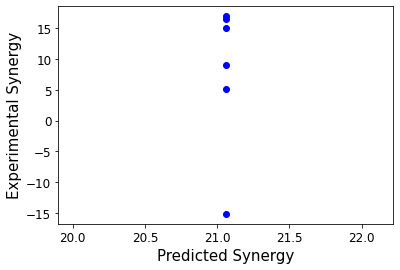

In [48]:
plt.plot(y_pred_ALK_CSNK2A1_2 , ALK_CSNK2A1_2_df["Synergy score"] , "bo")
plt.ylabel("Experimental Synergy", fontsize = 15)
plt.xlabel("Predicted Synergy", fontsize = 15)
plt.savefig("predicted_experimental_synergy_decision_tree_nan.eps", format = 'eps', dpi=300)


We will have to update our metric function to take this into account. But that's for anothe day. 



# Random Forest

In [49]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [50]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(24.352579, 26.538055)

A little better than the Tree regressor, but not that great.

In [51]:
y_pred = m.predict(valid_xs)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.16706360356491573
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.429530
1        FASN.MTOR_1     7            -0.013100
2         IAP.IGFR_3     3             0.884104
3        FGFR.MTOR_3     5             0.914940
4         IAP.PIK3CB    10             0.398945
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.755894
163      HSP90.PIK3C     3             0.304881
164  ATM.Gemcitabine     3            -0.278453
165     ATR_4.HDAC_4     3             0.999990
166   BCL2.CSNK2A1_2     6            -0.554555

[167 rows x 3 columns]


Let's try to obtain meaningful info. For example, let's order drug combinations from highest to lowest correlation

In [54]:
ordered_df = pear_weights_df.sort_values(by = "Pearson coefficient",
                                         ascending = False)
print(ordered_df)

        Combination ID  n_cl  Pearson coefficient
165       ATR_4.HDAC_4     3             0.999990
31            FGFR.WNT     3             0.999920
8    Gemcitabine.PARP1     3             0.999857
156  EG5.PIK3CB_PIK3CD     3             0.998560
151        MAP2K_1.TKI     3             0.998325
..                 ...   ...                  ...
145  AKT_1.Chloroquine     5            -0.803913
148    AKT.Chloroquine     5            -0.807129
77            IAP.SN38     3            -0.971769
65      IGFR_4.MAP2K_1     3            -0.992857
85      IGFR_3.MAP2K_1     3            -0.996501

[167 rows x 3 columns]


Now the most uncorrelated:

In [58]:
ordered_df["abs Pearson"] = np.abs(ordered_df["Pearson coefficient"])
ordered_df = ordered_df.sort_values(by ="abs Pearson",
                                         ascending = True)
ordered_df.head(10)

,Combination ID,n_cl,Pearson coefficient,abs Pearson
123,BCL2.MAP2K_1,3,0.005340,0.005340
122,FGFR.SLC16A4,6,-0.008699,0.008699
20,FGFR.TNKS_PARP6,7,-0.009324,0.009324
107,CarboTaxol.CSNK2A1_2,5,-0.009835,0.009835
1,FASN.MTOR_1,7,-0.013100,0.013100
137,AKT.HDAC_4,5,-0.015835,0.015835
117,ADAM17.BCL2_BCL2L1,7,0.022154,0.022154
13,ADAM17.PIK3CB_PIK3CD,8,-0.025216,0.025216
118,AKT.ATR_4,10,-0.027071,0.027071
149,Cisplatin.PARP1,3,0.028164,0.028164


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

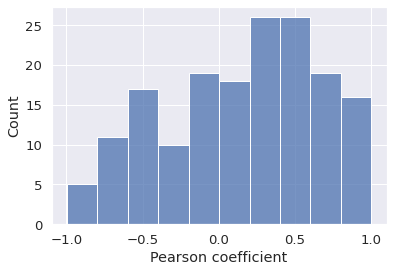

In [90]:
sns.histplot(data = ordered_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_random_forest.eps", format = 'eps', dpi=300)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Feature importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
7,H_A,0.131739
10,H_B,0.128231
8,Einf_A,0.126742
0,CELL_LINE,0.114278
11,Einf_B,0.103162
9,IC50_B,0.092686
6,IC50_A,0.088982
1,COMPOUND_A,0.078183
2,COMPOUND_B,0.072562
4,MAX_CONC_A,0.041318


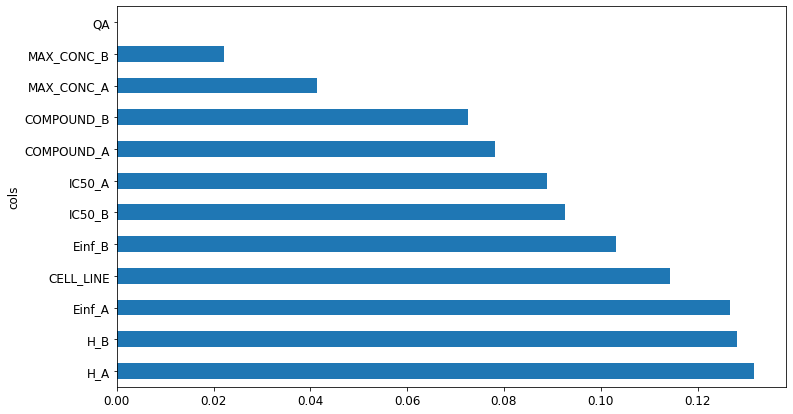

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Here we don't have a lot of columns, so we don't have
to erase any of them.